# Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

2025-12-27 22:23:45.884002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)
!python -V

Tensorflow version: 2.15.0
Tensorflow datasets version: 4.9.9
Python 3.11.0


# Setup Input Pipeline  

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2025-12-27 22:23:52.396086: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Lets put it this way. I actually get this movie. I get what the writer/directer was trying to do. I understand that the dialog was meant to be dry and emotionless. I understand that the plot was supposed to be non-climactic and stale. That was what the writer/director was going for. A very very very dry humor/comedy. With all that understanding, I still think the movie sucked. It seemed like the writer/director was trying to recreate Napolean Dynamite with this movie. It had all of the same features. Even the main character behaved similar to Napolean. But Napolean Dynamite was actually funny. Its script worked. This movie is not. It has no purpose. Well, let me rephrase that. Its only purpose is to rip off Napolean Dynamite and try to capture that look and feel. Too bad it didn't work."
 b"The ghost of the Vietnam war has haunted the American psyche for thirty years now. If not because of the fact that tens of thousands of American soldiers went MIA in Vietnam, or the manne

2025-12-27 22:23:52.693586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Text Encoder

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3]
encoded_example

<tf.Tensor: shape=(3, 1073), dtype=int64, numpy=
array([[599, 266,   9, ...,   0,   0,   0],
       [  2,   1,   5, ...,   0,   0,   0],
       [ 19,  11,  44, ...,   0,   0,   0]])>

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Lets put it this way. I actually get this movie. I get what the writer/directer was trying to do. I understand that the dialog was meant to be dry and emotionless. I understand that the plot was supposed to be non-climactic and stale. That was what the writer/director was going for. A very very very dry humor/comedy. With all that understanding, I still think the movie sucked. It seemed like the writer/director was trying to recreate Napolean Dynamite with this movie. It had all of the same features. Even the main character behaved similar to Napolean. But Napolean Dynamite was actually funny. Its script worked. This movie is not. It has no purpose. Well, let me rephrase that. Its only purpose is to rip off Napolean Dynamite and try to capture that look and feel. Too bad it didn't work."
Round-trip:  lets put it this way i actually get this movie i get what the [UNK] was trying to do i understand that the dialog was meant to be [UNK] and [UNK] i understand that the plot wa

# Model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00662064]


In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 142ms/step
[0.00662064]


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Training

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 256s 637ms/step - loss: 0.6491 - accuracy: 0.5540 - val_loss: 0.4865 - val_accuracy: 0.7839
Epoch 2/10


2025-12-27 22:28:16.878548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 225s 575ms/step - loss: 0.4544 - accuracy: 0.7989 - val_loss: 0.3872 - val_accuracy: 0.8286
Epoch 3/10


2025-12-27 22:32:01.751571: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 229s 585ms/step - loss: 0.3624 - accuracy: 0.8417 - val_loss: 0.3538 - val_accuracy: 0.8385
Epoch 4/10


2025-12-27 22:35:50.296103: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 242s 619ms/step - loss: 0.3368 - accuracy: 0.8553 - val_loss: 0.3374 - val_accuracy: 0.8578
Epoch 5/10


2025-12-27 22:39:52.197831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 237s 607ms/step - loss: 0.3251 - accuracy: 0.8612 - val_loss: 0.3290 - val_accuracy: 0.8635
Epoch 6/10


2025-12-27 22:43:49.348172: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 212s 543ms/step - loss: 0.3139 - accuracy: 0.8658 - val_loss: 0.3256 - val_accuracy: 0.8646
Epoch 7/10


2025-12-27 22:47:21.835476: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 220s 564ms/step - loss: 0.3092 - accuracy: 0.8683 - val_loss: 0.3242 - val_accuracy: 0.8562
Epoch 8/10


2025-12-27 22:51:02.241250: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 202s 516ms/step - loss: 0.3046 - accuracy: 0.8711 - val_loss: 0.3262 - val_accuracy: 0.8536
Epoch 9/10


2025-12-27 22:54:24.219740: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 204s 521ms/step - loss: 0.3002 - accuracy: 0.8727 - val_loss: 0.3194 - val_accuracy: 0.8625
Epoch 10/10


2025-12-27 22:57:47.960444: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 200s 511ms/step - loss: 0.2992 - accuracy: 0.8724 - val_loss: 0.3215 - val_accuracy: 0.8542


2025-12-27 23:01:07.759761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 54s 138ms/step - loss: 0.3165 - accuracy: 0.8576
Test Loss: 0.3164873421192169
Test Accuracy: 0.8575599789619446


## Plot the training history

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.666548390686512)

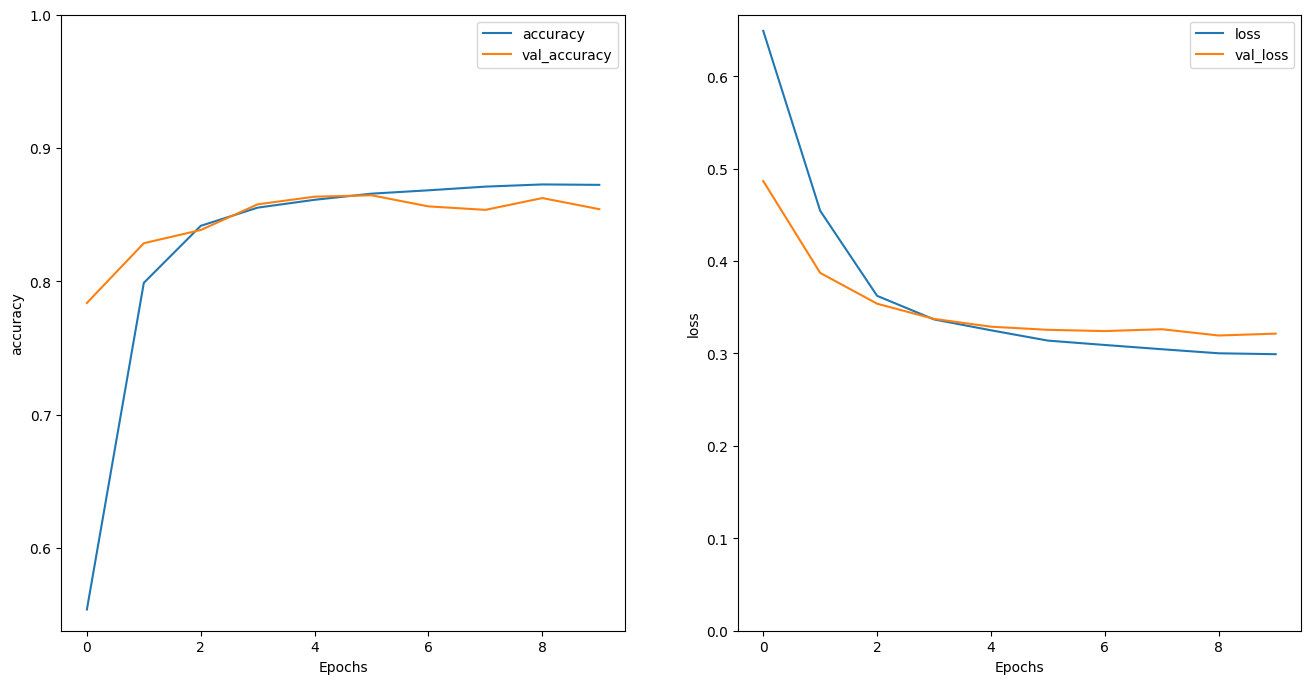

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions[0]

1/1 [==============================] - 2s 2s/step


array([0.6133292], dtype=float32)

## Stack two or more LSTM layers

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 421s 1s/step - loss: 0.6398 - accuracy: 0.5884 - val_loss: 0.5002 - val_accuracy: 0.7719
Epoch 2/10
391/391 [==============================] - 392s 1s/step - loss: 0.4070 - accuracy: 0.8172 - val_loss: 0.3619 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 398s 1s/step - loss: 0.3409 - accuracy: 0.8546 - val_loss: 0.3315 - val_accuracy: 0.8589
Epoch 4/10
391/391 [==============================] - 396s 1s/step - loss: 0.3213 - accuracy: 0.8625 - val_loss: 0.3290 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 392s 1s/step - loss: 0.3139 - accuracy: 0.8660 - val_loss: 0.3480 - val_accuracy: 0.8307
Epoch 6/10
391/391 [==============================] - 399s 1s/step - loss: 0.3119 - accuracy: 0.8651 - val_loss: 0.3230 - val_accuracy: 0.8484
Epoch 7/10
391/391 [==============================] - 399s 1s/step - loss: 0.3049 - accuracy: 0.8703 - val_loss: 0.3327 - val_accuracy: 0.8432

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 111s 285ms/step - loss: 0.3242 - accuracy: 0.8642
Test Loss: 0.32418492436408997
Test Accuracy: 0.8641600012779236


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-1.6518755]


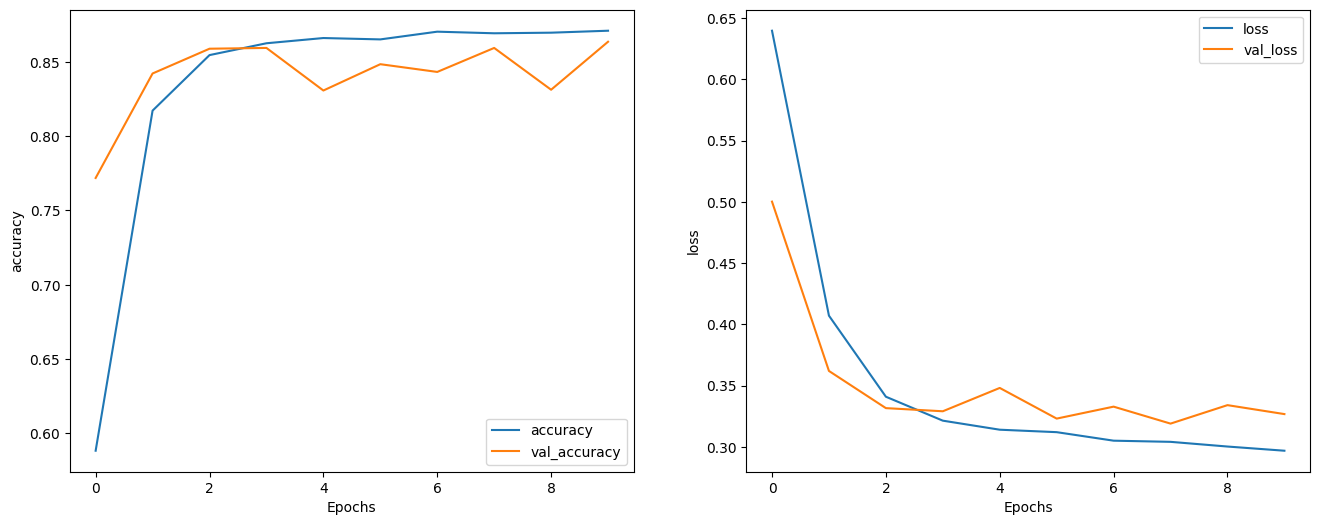

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')